№11
Побудувати CNN на основі DenceNet для класифікації зображень на основі
датасету fashion-mnist. Зробити налаштування моделі для досягнення
необхідної точності. На базі Siamese networks побудувати систему для пошуку
подібних зображень в датасеті fashion-mnist. Візуалізувати отримані
результати t-SNE.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the fashion-mnist dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values of the images to be between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Add a channel dimension to the images
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Define the input shape
input_shape = x_train[0].shape

# Define the DenseNet model
def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), 1, name=name + '_conv')(x)
    x = AveragePooling2D(pool_size=(1, 1), strides=(1, 1), padding="same")(x)
    return x

def conv_block(x, growth_rate, name):
    x1 = BatchNormalization(name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, name=name + '_1_conv')(x1)
    x1 = BatchNormalization(name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', name=name + '_2_conv')(x1)
    x = Concatenate(axis=-1, name=name + '_concat')([x, x1])
    return x

def DenseNet(input_shape, num_classes, blocks):
    inputs = tf.keras.Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same', name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    x = MaxPooling2D(3, strides=2, padding='same', name='pool1')(x)
    x = dense_block(x, blocks[0], name='dense_block1')
    x = transition_block(x, 0.5, name='transition_block1')
    x = dense_block(x, blocks[1], name='dense_block2')
    x = transition_block(x, 0.5, name='transition_block2')
    x = dense_block(x, blocks[2], name='dense_block3')
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu', name='relu2')(x)
    x = GlobalAveragePooling2D(name='pool2')(x)
    x = Dense(num_classes, activation='softmax', name='fc')(x)
    model = Model(inputs=inputs, outputs=x, name='DenseNet')
    return model

In [ ]:
input_shape = x_train[0].shape
num_classes = 10
blocks = [2, 4, 4]
# blocks = [4, 8, 16]

model = DenseNet(input_shape, num_classes, blocks)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x_train[:5000], y_train[:5000], epochs=7, validation_data=(x_test, y_test))

Epoch 1/7
157/157 [==============================] - 71s 412ms/step - loss: 0.6086 - accuracy: 0.7780 - val_loss: 4.7357 - val_accuracy: 0.1000
Epoch 2/7
157/157 [==============================] - 64s 409ms/step - loss: 0.4679 - accuracy: 0.8328 - val_loss: 2.9588 - val_accuracy: 0.3087
Epoch 3/7
157/157 [==============================] - 84s 540ms/step - loss: 0.4178 - accuracy: 0.8462 - val_loss: 0.7712 - val_accuracy: 0.7542
Epoch 4/7
157/157 [==============================] - 66s 421ms/step - loss: 0.3555 - accuracy: 0.8732 - val_loss: 0.5101 - val_accuracy: 0.8152
Epoch 5/7
157/157 [==============================] - 66s 424ms/step - loss: 0.3338 - accuracy: 0.8768 - val_loss: 0.6509 - val_accuracy: 0.7729
Epoch 6/7
157/157 [==============================] - 66s 421ms/step - loss: 0.2895 - accuracy: 0.8954 - val_loss: 0.5130 - val_accuracy: 0.8267
Epoch 7/7
157/157 [==============================] - 66s 422ms/step - loss: 0.2724 - accuracy: 0.8992 - val_loss: 0.5802 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

313/313 [==============================] - 21s 68ms/step - loss: 0.5802 - accuracy: 0.8087
Test accuracy: 0.8087000250816345


In [ ]:
from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_8[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 16)           336         ['merge_features[1][0

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

1/1 [==============================] - 0s 107ms/step


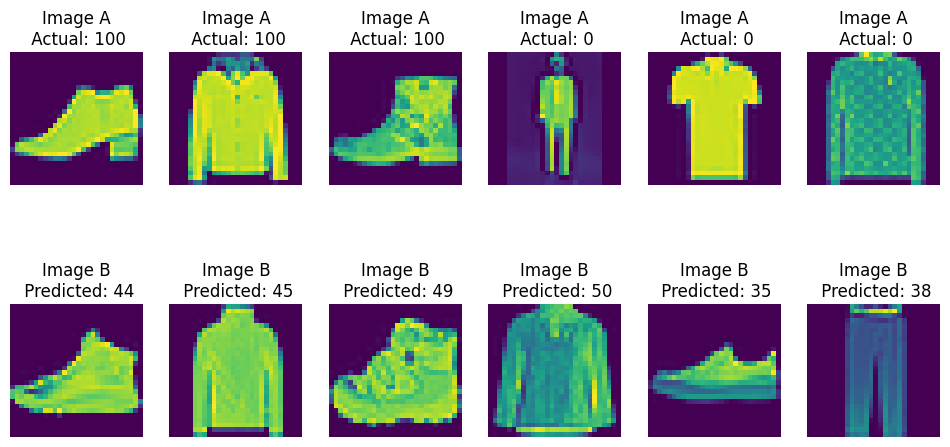

In [ ]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size = 64):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 100,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 4,
    verbose = True)

4/4 [==============================] - 0s 66ms/step
Epoch 1/4
500/500 [==============================] - 509s 1s/step - loss: 0.4167 - mae: 0.3068 - val_loss: 0.2908 - val_mae: 0.2040
Epoch 2/4
500/500 [==============================] - 475s 950ms/step - loss: 0.2582 - mae: 0.1728 - val_loss: 0.2364 - val_mae: 0.1465
Epoch 3/4
500/500 [==============================] - 510s 1s/step - loss: 0.2283 - mae: 0.1418 - val_loss: 0.2255 - val_mae: 0.1333
Epoch 4/4
4/4 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 26ms/step


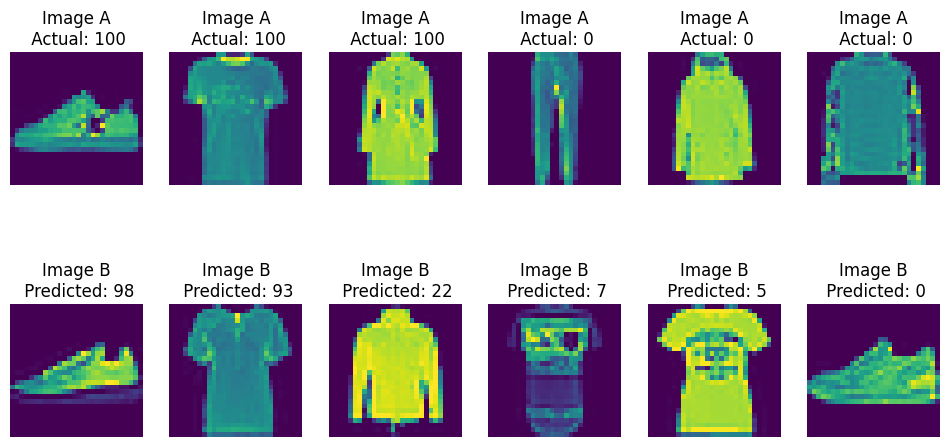

In [37]:
_ = show_model_output()

79/79 [==============================] - 32s 404ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 0.692s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.227585
[t-SNE] KL divergence a

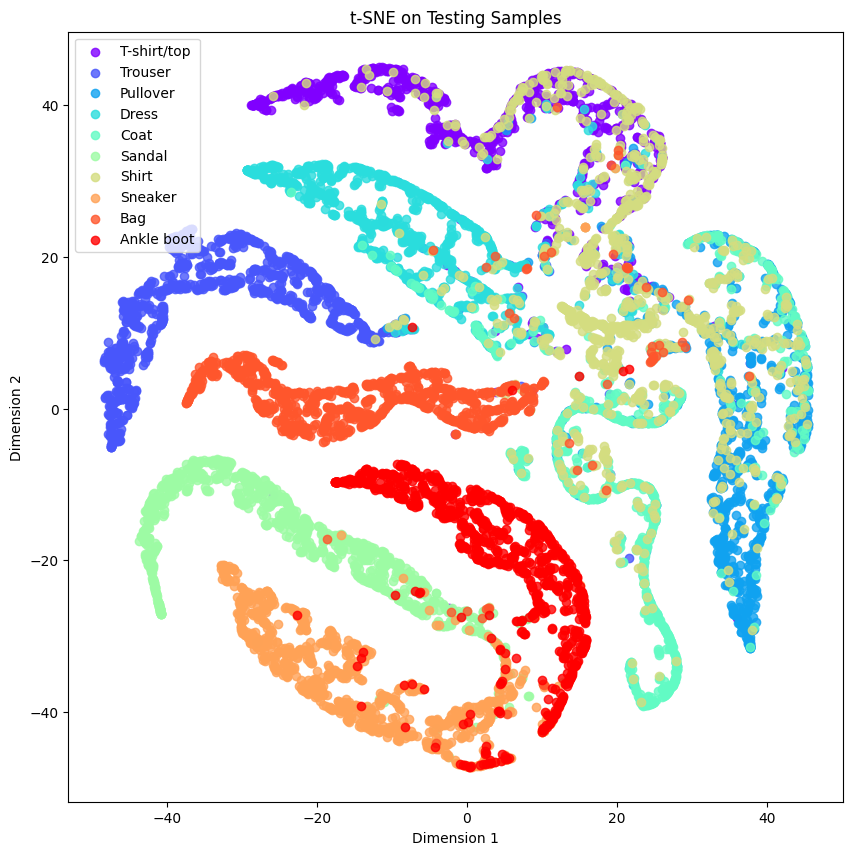

CPU times: user 1min 45s, sys: 600 ms, total: 1min 46s
Wall time: 1min 17s


In [38]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)